In [2]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [3]:
train_df = pd.read_csv("train.csv.zip")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\denni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Create a function for text preprocessing function which takes in a string of text as input and performs the following operations:

<li>Converts the text to lowercase
<li>Removes all punctuation marks
<li>Removes all English stopwords (i.e., common words such as 'the', 'and', 'a', etc.)
<li>Tokenizes the remaining words
<li>Removes any remaining numbers or special characters
<li>Joins the remaining words back into a string


In [5]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text into individual words
    words = word_tokenize(text)
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words and w not in string.punctuation]
    # Remove numbers and other special characters
    words = [re.sub(r'\d+', '', w) for w in words]
    words = [re.sub(r'[^\w\s]', '', w) for w in words]
    # Join the words back into a string
    text = " ".join(words)
    return text

In [6]:
train_df['cleaned_text'] = train_df['comment_text'].apply(preprocess_text)

In [7]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww matches background colour m seemingly stu...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man m really trying edit war s guy constan...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,ca nt make real suggestions improvement wonde...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page s


Reshape the label arrays y_toxic, y_stoxic, y_obscene, y_threat, y_insult, and y_idhate to be column vectors.

In [8]:
y_toxic = np.array(train_df["toxic"]).reshape(-1,1)
y_stoxic= np.array(train_df["severe_toxic"]).reshape(-1,1)
y_obscene = np.array(train_df["obscene"]).reshape(-1,1)
y_threat = np.array(train_df["threat"]).reshape(-1,1)
y_insult = np.array(train_df["insult"]).reshape(-1,1)
y_idhate = np.array(train_df["identity_hate"]).reshape(-1,1)
list_targets = [y_toxic, y_stoxic, y_obscene, y_threat, y_insult, y_idhate]

## toxic

In [9]:
np.unique(y_toxic, return_counts=True)

(array([0, 1], dtype=int64), array([144277,  15294], dtype=int64))

In [10]:
#stemmer_toxic = PorterStemmer()
#stemmer_toxic = SnowballStemmer()
#lemmatizer = WordNetLemmatizer()
#def stem_words(text):
    #return " ".join([stemmer_toxic.stem(word) for word in text.split()])

#NB Model
#model_nb_toxic = MultinomialNB()
model_nb_toxic = RandomForestClassifier()

vector_nb_toxic = TfidfVectorizer()
X_toxic = train_df["cleaned_text"]
X_train_toxic, X_test_toxic, y_train_toxic, y_test_toxic = train_test_split(X_toxic, y_toxic)

# build a Pipeline
pipe_nb_toxic = Pipeline([("vect", vector_nb_toxic),("model", model_nb_toxic)])

pipe_nb_toxic.fit(X_train_toxic, y_train_toxic.ravel())
preds_toxic = pipe_nb_toxic.predict(X_test_toxic)

print(classification_report(y_test_toxic, preds_toxic))
confusion_matrix(y_test_toxic, preds_toxic)


pipe_nb_toxic.fit(X_toxic, y_toxic.ravel())

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     36112
           1       0.92      0.56      0.70      3781

    accuracy                           0.95     39893
   macro avg       0.94      0.78      0.84     39893
weighted avg       0.95      0.95      0.95     39893



Pipeline(steps=[('vect', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

<AxesSubplot:>

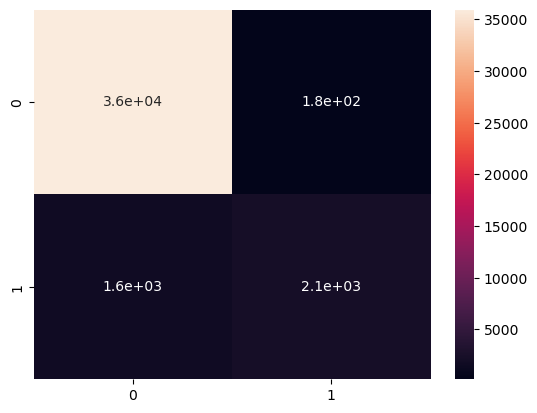

In [13]:
sns.heatmap(confusion_matrix(y_test_toxic, preds_toxic), annot=True)

At this point, I had tried add PorterStemmer() or SnowballStemmer(). The results looks almost the same.

## severe_toxic

In [11]:
np.unique(y_stoxic, return_counts=True)

(array([0, 1], dtype=int64), array([157976,   1595], dtype=int64))

In [12]:
model_nb_stoxic = RandomForestClassifier()

vector_nb_stoxic = TfidfVectorizer()
X_stoxic = train_df["cleaned_text"]
X_train_stoxic, X_test_stoxic, y_train_stoxic, y_test_stoxic = train_test_split(X_stoxic, y_stoxic)

# build a Pipeline
pipe_nb_stoxic = Pipeline([("vect", vector_nb_stoxic),("model", model_nb_stoxic)])

pipe_nb_stoxic.fit(X_train_stoxic, y_train_stoxic.ravel())
preds_stoxic = pipe_nb_stoxic.predict(X_test_stoxic)

print(classification_report(y_test_stoxic, preds_stoxic))
confusion_matrix(y_test_stoxic, preds_stoxic)


pipe_nb_stoxic.fit(X_stoxic, y_stoxic.ravel())

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39484
           1       0.65      0.07      0.12       409

    accuracy                           0.99     39893
   macro avg       0.82      0.53      0.56     39893
weighted avg       0.99      0.99      0.99     39893



Pipeline(steps=[('vect', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

<AxesSubplot:>

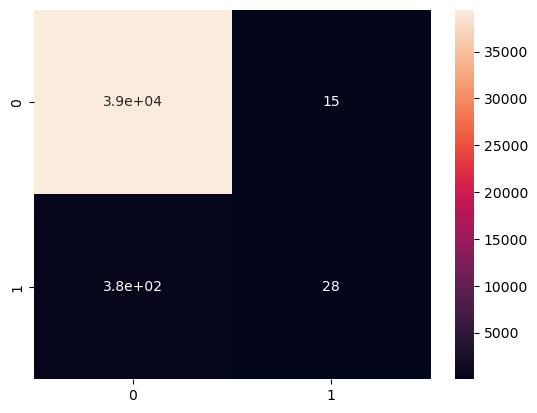

In [14]:
sns.heatmap(confusion_matrix(y_test_stoxic, preds_stoxic), annot=True)

## obscene

In [15]:
np.unique(y_obscene, return_counts=True)

(array([0, 1], dtype=int64), array([151122,   8449], dtype=int64))

In [16]:
model_nb_obscene = RandomForestClassifier()

vector_nb_obscene = TfidfVectorizer()
X_obscene = train_df["cleaned_text"]
X_train_obscene, X_test_obscene, y_train_obscene, y_test_obscene = train_test_split(X_obscene, y_obscene)

# build a Pipeline
pipe_nb_obscene = Pipeline([("vect", vector_nb_obscene),("model", model_nb_obscene)])

pipe_nb_obscene.fit(X_train_obscene, y_train_obscene.ravel())
preds_obscene = pipe_nb_obscene.predict(X_test_obscene)

print(classification_report(y_test_obscene, preds_obscene))
confusion_matrix(y_test_obscene, preds_obscene)


pipe_nb_obscene.fit(X_obscene, y_obscene.ravel())

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     37813
           1       0.91      0.64      0.75      2080

    accuracy                           0.98     39893
   macro avg       0.94      0.82      0.87     39893
weighted avg       0.98      0.98      0.98     39893



Pipeline(steps=[('vect', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

<AxesSubplot:>

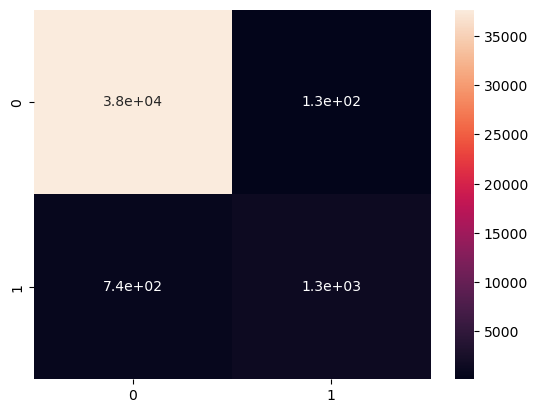

In [17]:
sns.heatmap(confusion_matrix(y_test_obscene, preds_obscene), annot=True)

## threat

In [18]:
np.unique(y_threat, return_counts=True)

(array([0, 1], dtype=int64), array([159093,    478], dtype=int64))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39760
           1       0.62      0.04      0.07       133

    accuracy                           1.00     39893
   macro avg       0.81      0.52      0.53     39893
weighted avg       1.00      1.00      1.00     39893



Pipeline(steps=[('vect', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

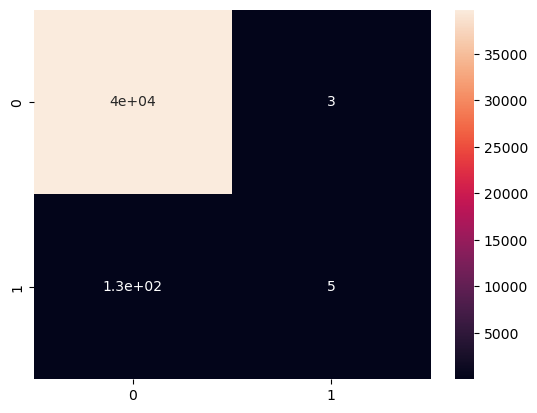

In [19]:
model_nb_threat = RandomForestClassifier()

vector_nb_threat = TfidfVectorizer()
X_threat = train_df["cleaned_text"]
X_train_threat, X_test_threat, y_train_threat, y_test_threat = train_test_split(X_threat, y_threat)

# build a Pipeline
pipe_nb_threat = Pipeline([("vect", vector_nb_threat),("model", model_nb_threat)])

pipe_nb_threat.fit(X_train_threat, y_train_threat.ravel())
preds_threat = pipe_nb_threat.predict(X_test_threat)

print(classification_report(y_test_threat, preds_threat))
sns.heatmap(confusion_matrix(y_test_threat, preds_threat), annot=True)


pipe_nb_threat.fit(X_threat, y_threat.ravel())

## insult

In [20]:
np.unique(y_insult, return_counts=True)

(array([0, 1], dtype=int64), array([151694,   7877], dtype=int64))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     37928
           1       0.82      0.47      0.60      1965

    accuracy                           0.97     39893
   macro avg       0.90      0.73      0.79     39893
weighted avg       0.97      0.97      0.96     39893



Pipeline(steps=[('vect', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

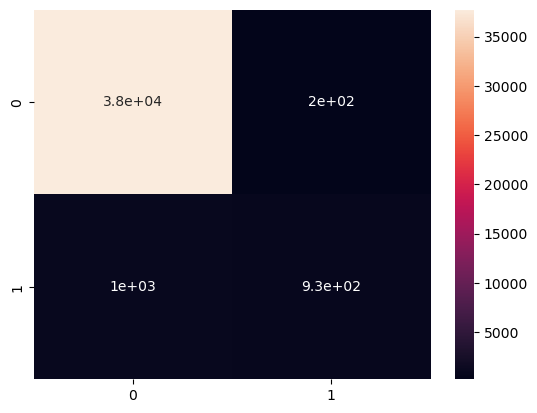

In [21]:
model_nb_insult = RandomForestClassifier()

vector_nb_insult = TfidfVectorizer()
X_insult = train_df["cleaned_text"]
X_train_insult, X_test_insult, y_train_insult, y_test_insult = train_test_split(X_insult, y_insult)

# build a Pipeline
pipe_nb_insult = Pipeline([("vect", vector_nb_insult),("model", model_nb_insult)])

pipe_nb_insult.fit(X_train_insult, y_train_insult.ravel())
preds_insult = pipe_nb_insult.predict(X_test_insult)

print(classification_report(y_test_insult, preds_insult))
sns.heatmap(confusion_matrix(y_test_insult, preds_insult), annot=True)


pipe_nb_insult.fit(X_insult, y_insult.ravel())

## identity_hate

In [22]:
np.unique(y_idhate, return_counts=True)

(array([0, 1], dtype=int64), array([158166,   1405], dtype=int64))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39524
           1       0.68      0.06      0.10       369

    accuracy                           0.99     39893
   macro avg       0.83      0.53      0.55     39893
weighted avg       0.99      0.99      0.99     39893



Pipeline(steps=[('vect', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

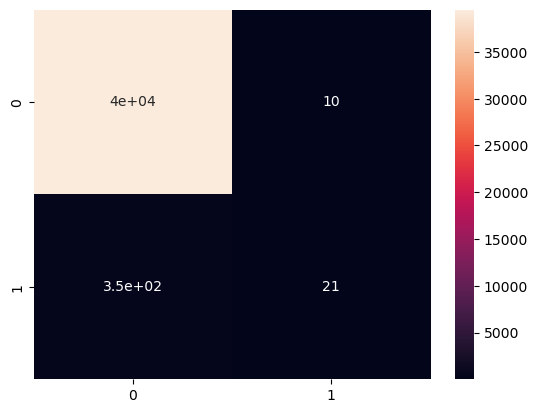

In [23]:
model_nb_idhate = RandomForestClassifier()

vector_nb_idhate = TfidfVectorizer()
X_idhate = train_df["cleaned_text"]
X_train_idhate, X_test_idhate, y_train_idhate, y_test_idhate = train_test_split(X_idhate, y_idhate)

# build a Pipeline
pipe_nb_idhate = Pipeline([("vect", vector_nb_idhate),("model", model_nb_idhate)])

pipe_nb_idhate.fit(X_train_idhate, y_train_idhate.ravel())
preds_idhate = pipe_nb_idhate.predict(X_test_idhate)

print(classification_report(y_test_idhate, preds_idhate))
sns.heatmap(confusion_matrix(y_test_idhate, preds_idhate), annot=True)


pipe_nb_idhate.fit(X_idhate, y_idhate.ravel())

## Summary

<li>Define a function preprocess_text to preprocess the comment text by converting it to lowercase, tokenizing it into individual words, removing stopwords and punctuation, removing numbers and special characters, and joining the words back into a string.

<li>Reshape the label arrays y_toxic, y_stoxic, y_obscene, y_threat, y_insult, and y_idhate to be column vectors.

<li>Create a RandomForestClassifier object and a TfidfVectorizer object.

<li>Split the data into training and testing sets using the train_test_split function.

<li>Create a Pipeline object that combines the TfidfVectorizer and RandomForestClassifier objects into a single entity.

<li>Fit the Pipeline object to the training data using the fit method.

<li>Use the Pipeline object to predict labels for the test data using the predict method.

<li>Print the classification report and confusion matrix to evaluate the performance of the model on the test data.

<li>Fit the Pipeline object to the entire dataset.

## Test Data

In [ ]:
test_df = pd.read_csv("test.csv")
test_df.head()

## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [ ]:
#Construct dummy data for a sample output. 
#You won't do this part first, you have real data - I'm faking it. 
#Your data should have the same structure, so the CSV output is the same
dummy_ids = ["dfasdf234", "asdfgw43r52", "asdgtawe4", "wqtr215432"]
dummy_toxic = [0,0,0,0]
dummy_severe = [0,0,0,0]
dummy_obscene = [0,1,1,0]
dummy_threat = [0,1,0,1]
dummy_insult = [0,0,1,0]
dummy_ident = [0,1,1,0]
columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_out = pd.DataFrame( list(zip(dummy_ids, dummy_toxic, dummy_severe, dummy_obscene, dummy_threat, dummy_insult, dummy_ident)),
                    columns=columns)
sample_out.head()

In [ ]:
#Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
#This command should work with your dataframe of predictions. 
sample_out.to_csv('out.csv', index=False)  

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>